## Reference:

Ye, H. (2019). Accurate image reconstruction in radio interferometry (Doctoral thesis). https://doi.org/10.17863/CAM.39448

Haoyang Ye, Stephen F Gull, Sze M Tan, Bojan Nikolic, Optimal gridding and degridding in radio interferometry imaging, Monthly Notices of the Royal Astronomical Society, Volume 491, Issue 1, January 2020, Pages 1146–1159, https://doi.org/10.1093/mnras/stz2970

Github: https://github.com/zoeye859/Imaging-Tutorial

In [1]:
%matplotlib notebook
import numpy as np
from scipy.optimize import leastsq, brent
from scipy.linalg import solve_triangular
import matplotlib.pyplot as plt
import scipy.integrate as integrate
from time import process_time
from numpy.linalg import inv
np.set_printoptions(precision=16)
from Imaging_core import *
from Gridding_core import *
import pickle
with open("min_misfit_gridding_7.pkl", "rb") as pp:
    opt_funcs = pickle.load(pp)

### 1. Read in the data

In [2]:
#########  Read in visibilities ##########
data = np.genfromtxt('simul3d.csv', delimiter = ',')
jj = complex(0,1)
u_original = data.T[2][1:]
v_original = data.T[3][1:]
w_original = data.T[4][1:]
V_original = data.T[5][1:] + jj*data.T[6][1:]
n_uv = len(u_original)
uv_max = max(np.sqrt(u_original**2+v_original**2))
V,u,v,w = Visibility_minusw(V_original,u_original,v_original,w_original)

#### Determine the pixel size ####
X_size = 300 # image size on x-axis
Y_size = 300 # image size on y-axis
X_min = -1.15/2 #You can change X_min and X_max in order to change the pixel size.
X_max = 1.15/2
X = np.linspace(X_min, X_max, num=X_size+1)[0:X_size]
Y_min = -1.15/2 #You can change Y_min and Y_max in order to change the pixel size.
Y_max = 1.15/2
Y = np.linspace(Y_min,Y_max,num=Y_size+1)[0:Y_size]
pixel_resol_x = 180. * 60. * 60. * (X_max - X_min) / np.pi / X_size
pixel_resol_y = 180. * 60. * 60. * (Y_max - Y_min) / np.pi / Y_size
print ("The pixel size on x-axis is ", pixel_resol_x, " arcsec") 

The pixel size on x-axis is  790.681757280536  arcsec


### 2. determine the number of w planes 

Here is a short introduction to the original W-Stacking method (Offringa, 2014). Starting from 

$V(u,v,w) = \int\int \frac{\text{d}l \text{d}m }{\sqrt{1-l^2-m^2}}I(l,m)\exp\left[-i2\pi\left(ul+vm+w\left(\sqrt{1-l^2-m^2}-1\right)\right)\right]	$

The right-hand side can be separated into one part without any $w$-term and the rest which contains the $w$-term. For each given non--zero $w_i$, we have

$V(u,v,w_i) = \int \int \mathrm{d}l \mathrm{d}m \frac{I(l,m)}{\sqrt{1-l^2-m^2}} \exp{[-i2\pi(ul+vm)]}\exp{\Big\{-i2\pi\Big[w_i\Big(\sqrt{1-l^2-m^2}-1\Big)\Big]}\Big\}$

For each given non-zero $w_i$, this is essentially a two--dimensional Fourier transform. By inverting the transform, we have:

$\frac{I(l,m)}{\sqrt{1-l^2-m^2}} = \int \int \mathrm{d}u \mathrm{d}v V(u,v,w_i)\exp{[i2\pi(ul+vm)]}	\exp{\Big\{i2\pi\Big[w_i\Big(\sqrt{1-l^2-m^2}-1\Big)\Big]}\Big\} $

If we integrate both sides along the $w$-axis from the minimum $w_{\rm min}$ to the maximum $w_{\rm max}$ on the right-hand side, the result is

$\frac{I(l,m)(w_{\rm max} - w_{\rm min})}{\sqrt{1-l^2-m^2}} = \int_{w_{\rm min}}^{w_{\rm max}} \mathrm{d}w \exp{\Big\{\mathrm{i}2\pi\Big[w\Big(\sqrt{1-l^2-m^2}-1\Big)\Big]}\Big\}$
$\int \int \mathrm{d}u \mathrm{d}v V(u,v,w)\exp{[i2\pi(ul+vm)]}$

In practice, the values of $w$ are discretised into $N_w$ uniform samples along the $w$-axis,  can be written as:

$\frac{I(l,m)(w_{\rm max} - w_{\rm min})}{\sqrt{1-l^2-m^2}} = \sum_{n = 0}^{N_w-1}\exp{\Big\{i2\pi\Big[w_n\Big(\sqrt{1-l^2-m^2}-1\Big)\Big]}\Big\}\int \int \mathrm{d}u \mathrm{d}v V(u,v,w_n)\exp{[i2\pi(ul+vm)]} $

Following (Offringa, 2014), the separation of two subsequent $w$ values $\delta w$ should satisfy the criterion:

$|\delta w 2\pi(\sqrt{1-l^2-m^2}-1)| \ll 1$

If $\delta w$ is larger than this, more $w$ samples are needed. Hence, $N_w$ is determined by:

$N_w \geq 2\pi(w_{\rm max} - w_{\rm min})\max_{l,m}(1-\sqrt{1-l^2-m^2})$



### 2.1 Redetermin the number of w planes

<img src="normalised_coordinate.png">

In the normalised coordinate system plotted above, the field of view is confined in the region of $[-0.5,0.5]$. $x_0$ and $y_0$ represents how much of the image will be cropped after the FFT process （Ye,2019 on optimal gridding and degridding）. Here we have $x_0 = y_0$. The angular size of the map required for the FFT in $l$ is $l_{\rm range}/(2x_0)$, and is $N_x$ pixels. If $u$ is specified in wavelengths, it is multiplied by $l_{\rm range}/(2x_0)$ to convert to pixels, so that we redetermin the number of $w$-planes as:

$N_x \geq (u_{\rm max}-u_{\rm min})l_{\rm range}/x_0$

We now consider the choice of the $w$ or $z$ grid. We set the phase centre $z=0$ at $n=0$ and $z=-x_0$ at $n_{\rm min}$. In our improved W-Stacking, we do not apply FFT in the $z$ direction, so there is no advantage in oversampling the beam considerably. Consequently,

$N_z \geq (w_{\rm max}-w_{\rm min})n_{\rm min}/x_0$

The number of $w$-planes using least-misfit gridding function can therefore be determined as:

$N_{w'} \equiv N_z \geq\frac{\max_{l,m}(1-\sqrt{1-l^2-m^2})(w_{\rm max} - w_{\rm min})}{x_0} + W$

The additional $w$-planes enable visibilities located close to the top or bottom $w$-planes to be gridded to grids on both sides.

The number of $w$-planes, $N_{w}$, determined by the original W-Stacking method is more than 1.5 times greater than the first part of $N_{w'}$. Thus, for given data, the improved W-Stacking method may require fewer $w$--planes than the original W-Stacking method. $x_0 = 0.25, W\geq 7$ is recommended so as to achieve the single precision limit in the image misfit level.



### 2. Determine w plane number Nw_2R


In [3]:
W = 6
x0=0.25
Nw_2R, w_values, dw = Wplanes(W, X_max, Y_max, w, x0)

We will have 75 w-planes


### 3 3D Gridding + Imaging + Correcting

To know more about gridding, you can refer to https://github.com/zoeye859/Imaging-Tutorial 
#### Calculating gridding values for w respectively

In [4]:
Nfft = 600
im_size = 600
W = 6
M, x0, h = opt_funcs[W].M, opt_funcs[W].x0, opt_funcs[W].h
ind = find_nearestw(w_values, w)
C_w = cal_grid_w(w, w_values, ind, dw, W, h, M)

Elapsed time during the w gridding value calculation in seconds: 0.9928899999999998


#### Gridding on w-axis

In [5]:
bEAM = np.ones(n_uv)
V_wgrid = np.zeros((Nw_2R,1),dtype = np.complex_).tolist()
beam_wgrid = np.zeros((Nw_2R,1),dtype = np.complex_).tolist()
u_wgrid = np.zeros((Nw_2R,1)).tolist()
v_wgrid = np.zeros((Nw_2R,1)).tolist()
R = W//2
t2_start = process_time() 

for k in range(n_uv):
    C_wk = C_w[k]
    w_plane = ind[k]
    for n in range(-R+1,R+1):
        V_wgrid[w_plane+n] += [C_wk[n+R-1,0] * V[k]]
        u_wgrid[w_plane+n] += [u[k]]
        v_wgrid[w_plane+n] += [v[k]]
        beam_wgrid[w_plane+n] += [C_wk[n+R-1,0] * bEAM[k]]

t2_stop = process_time()   
print("Elapsed time during the w-gridding calculation in seconds:", t2_stop-t2_start)  

Elapsed time during the w-gridding calculation in seconds: 0.16977900000000012


In [6]:
for i in range(Nw_2R):
    del(V_wgrid[i][0])
    del(u_wgrid[i][0])
    del(v_wgrid[i][0])
    del(beam_wgrid[i][0])

#### Imaging

In [7]:
I_size = int(im_size*2*x0)
V_grid = np.zeros((im_size,im_size),dtype = np.complex_)
B_grid = np.zeros((im_size,im_size),dtype = np.complex_) 
I_image = np.zeros((I_size,I_size),dtype = np.complex_)
B_image = np.zeros((I_size,I_size),dtype = np.complex_)


t2_start = process_time() 
for w_ind in range(Nw_2R):
    print ('Gridding the ', w_ind, 'th level facet out of ',Nw_2R,' w facets.\n')
    V_update = np.asarray(V_wgrid[w_ind])
    u_update = np.asarray(u_wgrid[w_ind])
    v_update = np.asarray(v_wgrid[w_ind])
    beam_update = np.asarray(beam_wgrid[w_ind])
    C_u, u_grid = cal_grid_uv(u_update, W, im_size, X_max, X_min, h, M, x0=0.25)
    C_v, v_grid = cal_grid_uv(v_update, W, im_size, Y_max, Y_min, h, M, x0=0.25)
    for k in range(0,len(V_wgrid[w_ind])):
        C_uk = C_u[k]
        C_vk = C_v[k]
        u_index = np.int(np.floor(u_grid[k]))
        v_index = np.int(np.floor(v_grid[k]))
        for m in range(-R+1,R+1):
            for n in range(-R+1,R+1):
                V_grid[u_index+m,v_index+n] += C_uk[m+R-1] * C_vk[n+R-1] * V_update[k]
                B_grid[u_index+m,v_index+n] += C_uk[m+R-1] * C_vk[n+R-1] * beam_update[k]
    print ('FFT the ', w_ind, 'th level facet out of ',Nw_2R,' w facets.\n')
    I_image += FFTnPShift(V_grid, w_values[w_ind], X, Y, im_size, x0)
    B_image += FFTnPShift(B_grid, w_values[w_ind], X, Y, im_size, x0)
    B_grid = np.zeros((im_size,im_size),dtype = np.complex_) 
    V_grid = np.zeros((im_size,im_size),dtype = np.complex_)
    
t2_stop = process_time()   
print("Elapsed time during the uv-gridding calculation in seconds:", t2_stop-t2_start)  

Gridding the  0 th level facet out of  75  w facets.

Elapsed time during the u/v gridding value calculation in seconds: 0.04421499999999989
Elapsed time during the u/v gridding value calculation in seconds: 0.03439199999999998
FFT the  0 th level facet out of  75  w facets.

FFTing...
Phaseshifting...
FFTing...
Phaseshifting...
Gridding the  1 th level facet out of  75  w facets.

Elapsed time during the u/v gridding value calculation in seconds: 0.08160999999999996
Elapsed time during the u/v gridding value calculation in seconds: 0.0703100000000001
FFT the  1 th level facet out of  75  w facets.

FFTing...
Phaseshifting...
FFTing...
Phaseshifting...
Gridding the  2 th level facet out of  75  w facets.

Elapsed time during the u/v gridding value calculation in seconds: 0.11314099999999971
Elapsed time during the u/v gridding value calculation in seconds: 0.11630399999999952
FFT the  2 th level facet out of  75  w facets.

FFTing...
Phaseshifting...
FFTing...
Phaseshifting...
Gridding

FFTing...
Phaseshifting...
Gridding the  25 th level facet out of  75  w facets.

Elapsed time during the u/v gridding value calculation in seconds: 0.12534899999999993
Elapsed time during the u/v gridding value calculation in seconds: 0.1241369999999975
FFT the  25 th level facet out of  75  w facets.

FFTing...
Phaseshifting...
FFTing...
Phaseshifting...
Gridding the  26 th level facet out of  75  w facets.

Elapsed time during the u/v gridding value calculation in seconds: 0.12361300000000597
Elapsed time during the u/v gridding value calculation in seconds: 0.12613600000000247
FFT the  26 th level facet out of  75  w facets.

FFTing...
Phaseshifting...
FFTing...
Phaseshifting...
Gridding the  27 th level facet out of  75  w facets.

Elapsed time during the u/v gridding value calculation in seconds: 0.11422900000000169
Elapsed time during the u/v gridding value calculation in seconds: 0.11353499999999883
FFT the  27 th level facet out of  75  w facets.

FFTing...
Phaseshifting...
FF

FFTing...
Phaseshifting...
Gridding the  50 th level facet out of  75  w facets.

Elapsed time during the u/v gridding value calculation in seconds: 0.022065999999995256
Elapsed time during the u/v gridding value calculation in seconds: 0.0216829999999959
FFT the  50 th level facet out of  75  w facets.

FFTing...
Phaseshifting...
FFTing...
Phaseshifting...
Gridding the  51 th level facet out of  75  w facets.

Elapsed time during the u/v gridding value calculation in seconds: 0.02478399999999681
Elapsed time during the u/v gridding value calculation in seconds: 0.019586000000003878
FFT the  51 th level facet out of  75  w facets.

FFTing...
Phaseshifting...
FFTing...
Phaseshifting...
Gridding the  52 th level facet out of  75  w facets.

Elapsed time during the u/v gridding value calculation in seconds: 0.025021000000009508
Elapsed time during the u/v gridding value calculation in seconds: 0.018140000000002487
FFT the  52 th level facet out of  75  w facets.

FFTing...
Phaseshifting..

FFTing...
Phaseshifting...
Elapsed time during the uv-gridding calculation in seconds: 85.94023200000001


#### Rescale and have a look

<IPython.core.display.Javascript object>


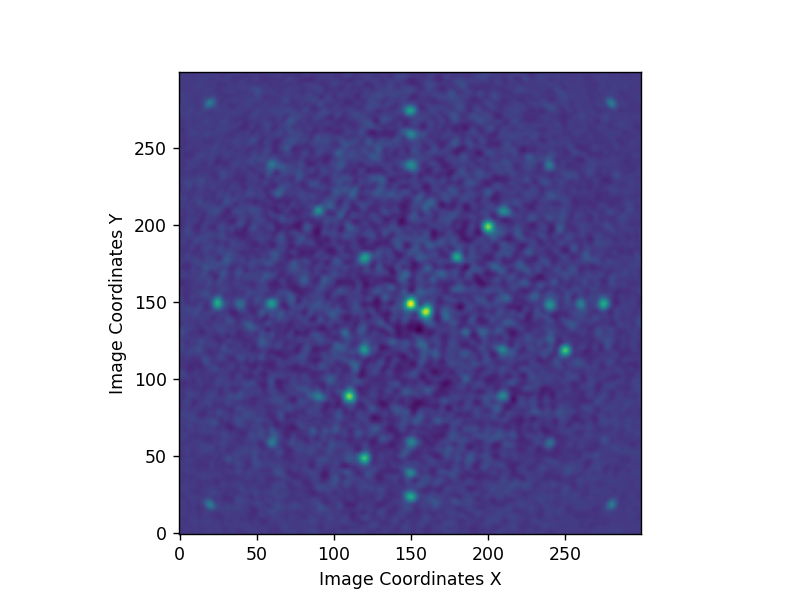

(1.0000000022353488+0j)

In [8]:
I_image_now = image_rescale(I_image,im_size, n_uv)
B_image_now = image_rescale(B_image,im_size, n_uv)
plt.figure()
plt.imshow(np.rot90(I_image_now.real,1), origin = 'lower')
plt.xlabel('Image Coordinates X')
plt.ylabel('Image Coordinates Y')
plt.show()
B_image_now[150,150]

#### Correcting functions h(x)h(y) on x and y axis

#### W= 6, x0 = 0.25

In [9]:
Nfft = 600
# Use these for calculating gridding correction on the FFT grid
M = 32
I_xycorrected = xy_correct(I_image_now, opt_funcs[6], im_size, x0=0.25)
B_xycorrected = xy_correct(B_image_now, opt_funcs[6], im_size, x0=0.25)

#### Correcting function on z axis

In [10]:
Cor_gridz = z_correct_cal(X_min, X_max, Y_min, Y_max, dw, h, im_size, W, M, x0)
I_zcorrected = z_correct(I_xycorrected, Cor_gridz, im_size, x0=0.25)
B_zcorrected = z_correct(B_xycorrected, Cor_gridz, im_size, x0=0.25)

### 4 DFT and FFT dirty image difference

In [11]:
I_DFT = np.loadtxt('I_DFT_simul300.csv', delimiter = ',')

<IPython.core.display.Javascript object>


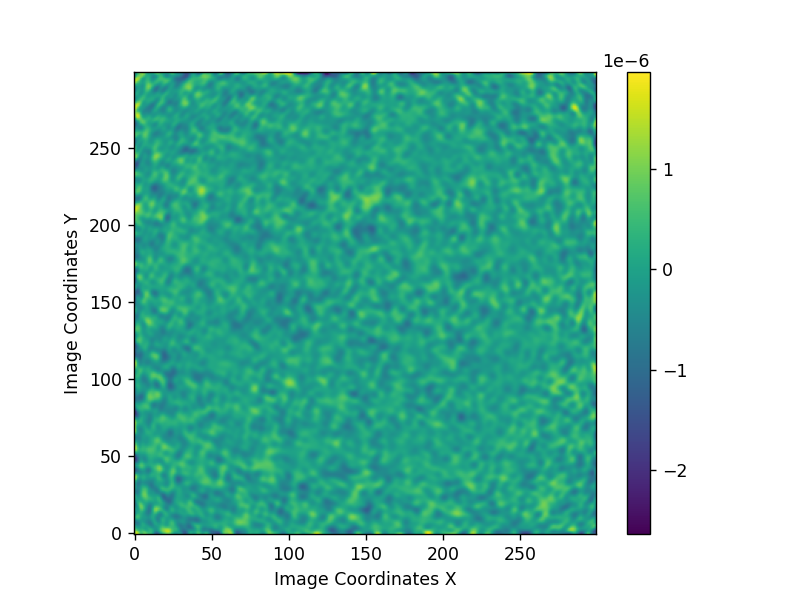

In [12]:
I_dif = I_DFT - I_zcorrected.real
rms = RMS(I_dif, im_size, 0.5, x0=0.25)
plt.figure()
plt.imshow(np.rot90(I_dif,1), origin = 'lower')
plt.colorbar()
plt.xlabel('Image Coordinates X')
plt.ylabel('Image Coordinates Y')
plt.show()

In [15]:
print (rms)

3.1153852973496086e-07
